## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

Import the necessary modules:

In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-17 13:04:32.212962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data handling

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

In [2]:
from lib_util import utils
from sklearn.model_selection import train_test_split

config = utils.get_config('transformer_exp')

melspec_data = utils.load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

labels_to_id = utils.get_class_mapping()

mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=config['train_set_size'], random_state=config['random_state'])
mel_val, mel_test, lab_val, lab_test             = train_test_split(mel_test_val, lab_test_val, test_size=(config['val_set_size']/(1-config['train_set_size'])), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]

# read in the config
pp_config = utils.get_config('preprocess')

n_mels = pp_config['melspectogram']['n_mels']
mel_train = mel_train.reshape(mel_train.shape[0], -1, n_mels)
mel_val   = mel_val.reshape(mel_val.shape[0], -1, n_mels)
mel_test   = mel_test.reshape(mel_test.shape[0], -1, n_mels)

train_dataset = tf.data.Dataset.from_tensor_slices((mel_train, lab_train))
val_dataset = tf.data.Dataset.from_tensor_slices((mel_val, lab_val))
test_dataset = tf.data.Dataset.from_tensor_slices((mel_test, lab_test))

Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)


2023-01-17 13:04:42.752153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

### Set up a data pipeline with `tf.data`

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [3]:
BUFFER_SIZE = 20000
BATCH_SIZE = 128

In [4]:
def make_batches(ds):
  return (
      ds
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset 

In [5]:
# Create training and validation set batches.
train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)
test_batches = make_batches(test_dataset)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Protugese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

## Define the components

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [6]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [7]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, d_model):
    super().__init__()
    self.d_model = d_model
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def call(self, x):
    length = tf.shape(x)[1]
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [8]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [9]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Test run it on sample inputs:

In [10]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [11]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [12]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

Here is the definition of the `EncoderLayer`:

In [13]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

### The encoder

Next build the encoder.

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [19]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    # self.pos_embedding = PositionalEmbedding(d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    # x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

Create the `Transformer` by extending `tf.keras.Model`:

In [20]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, n_labels,
               dropout_rate=0.1):
    super().__init__()

    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           dropout_rate=dropout_rate)

    self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
    self.pooling_layer = tf.keras.layers.GlobalAvgPool1D()
    self.dense_layer = tf.keras.layers.Dense(4 * n_labels, 'selu')
    self.final_layer = tf.keras.layers.Dense(n_labels, activation='sigmoid')

    self.softmax = tf.keras.layers.Softmax()

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.

    context = self.encoder(inputs)  # (batch_size, context_len, d_model)

    context = self.dropout_layer(context)

    context = self.pooling_layer(context)

    context = self.dense_layer(context)

    # Final linear layer output.
    out = self.final_layer(context)  # (batch_size, target_len, target_vocab_size)

    return out

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [21]:
num_layers = 8
d_model = 128
dff = 256
num_heads = 8
dropout_rate = 0.2

### Try it out

Instantiate the `Transformer` model:

In [22]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    dropout_rate=dropout_rate,
    n_labels=lab_train.shape[1])

Print the summary of the model:

In [23]:
transformer.build((None, None,  128))
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  4751360   
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 global_average_pooling1d_1   multiple                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_34 (Dense)            multiple                  2580      
                                                                 
 dense_35 (Dense)            multiple                  105       
                                                                 
 softmax_1 (Softmax)         multiple                  0 (unused)
                                                     

In [30]:
dot_img_file = '/Plots/my_transformer_architecture.png'
tf.keras.utils.plot_model(transformer, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [32]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [33]:
transformer.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.BinaryAccuracy()])

In [34]:
es = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3
)

hist = transformer.fit(train_batches,
                epochs=20,
                callbacks=[es],
                validation_data=val_batches)

Epoch 1/20
20/20 [==============================] - 701s 34s/step - loss: 0.8160 - binary_accuracy: 0.3782 - val_loss: 0.5688 - val_binary_accuracy: 0.7690
Epoch 2/20
20/20 [==============================] - 690s 35s/step - loss: 0.5343 - binary_accuracy: 0.7925 - val_loss: 0.5908 - val_binary_accuracy: 0.8000
Epoch 3/20
20/20 [==============================] - 654s 33s/step - loss: 0.5019 - binary_accuracy: 0.8000 - val_loss: 0.5507 - val_binary_accuracy: 0.7870
Epoch 4/20
20/20 [==============================] - 667s 33s/step - loss: 0.4894 - binary_accuracy: 0.8000 - val_loss: 0.5777 - val_binary_accuracy: 0.7617
Epoch 5/20
20/20 [==============================] - 675s 34s/step - loss: 0.4823 - binary_accuracy: 0.7996 - val_loss: 0.5734 - val_binary_accuracy: 0.7614
Epoch 6/20
20/20 [==============================] - 678s 34s/step - loss: 0.4706 - binary_accuracy: 0.8016 - val_loss: 0.6683 - val_binary_accuracy: 0.7398


In [ ]:
transformer.save_weights('models/my_transformer')

available keys dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


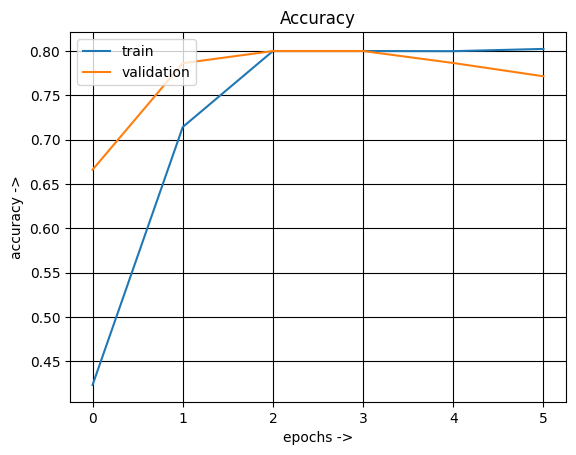

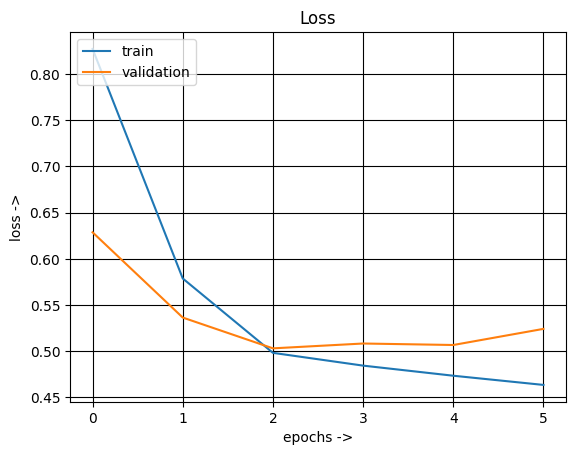

In [ ]:
from lib_util import plot
epochs= 20
history_dict = utils.load_history('my_transformer')

print('available keys', history_dict.keys())

#Plots for the accuracies and losses of the train and validation data per epoch
plot.plot_hist(history_dict, ('binary_accuracy', 'val_binary_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->', save_to=f'Plots/short_chunk_cnn_{epochs}_acuracy')
plot.plot_hist(history_dict, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->', save_to=f'Plots/short_chunk_cnn_{epochs}_loss')

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Test prediction
scores = transformer.evaluate(mel_test, lab_test)

y_pred = transformer.predict(mel_test)

In [51]:
y_pred_m = np.argmax(y_pred, axis=1)

print(np.sum(y_pred_m==np.argmax(lab_test, axis=1))/y_pred_m.shape[0])

print(np.unique(y_pred_m))

0.32432432432432434
[0 2 3]
